## Breast Cancer prediction:
The dataset is huge so we are aiming to preprocess it before training it on models
We will start by importing some libraries:

In [204]:
#importing the necessary libraries
import pandas as pd
import numpy as np


### Step 1: Read data and check missing values...

In [205]:
#Reading the data and checking number of missing values and duplicate rows
data = pd.read_csv("data.csv")
print(data.head())
print("\nData Shape: ", data.shape)

print("\nNumber of duplicated rows: ", data.duplicated().sum())

print("\nNumber of Missing Values per column: ", data.isna().sum())


                        cancer_type  patient_id  age_at_diagnosis cellularity  \
0  Breast Invasive Ductal Carcinoma         474             54.29        High   
1  Breast Invasive Ductal Carcinoma        7029             43.45    Moderate   
2  Breast Invasive Ductal Carcinoma        5215             74.11        High   
3  Breast Invasive Ductal Carcinoma        5412             51.87        High   
4  Breast Invasive Ductal Carcinoma         465             87.18    Moderate   

   chemotherapy pam50_+_claudin-low_subtype  cohort er_status_measured_by_ihc  \
0             1                        LumB       1                   Positve   
1             0                        LumA       4                   Positve   
2             0                        LumB       3                   Positve   
3             0                        LumA       3                   Positve   
4             0                        LumB       1                   Positve   

  er_status  neoplasm_hist

/var/folders/9b/n7j6vvys083g7009y7vtvlh00000gn/T/ipykernel_74992/4101382351.py:2: DtypeWarning: Columns (662,664,676,677,683,685,686,687) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("data.csv")


### Step 2: Drop the unnecessary columns and outliers

In [206]:
#Filling out the one record with the missing cause of death
data.loc[data['patient_id'] == 5130, 'death_from_cancer'] = 'Died of Disease'

#Dropping irrelevant columns
data = data.drop(columns=["er_status_measured_by_ihc", "radio_therapy", "primary_tumor_laterality", "chemotherapy", "patient_id", "3-gene_classifier_subtype", "cohort"])

#Dropping outliers
data.drop(data[data['pam50_+_claudin-low_subtype'] == 'NC'].index, inplace=True)
data.drop(data[data['tumor_stage'] == '0'].index, inplace=True)


### Step 3: Complete the missing records

##### 1) Completing the missing **tumor_size** records

In [207]:
# Dropping rows with missing 'tumor_size' values
temp_data = data.dropna(subset=['tumor_size'])

# Grouping the data by 'cancer_type' and 'pam50_+_claudin-low_subtype' on 'tumor_size'
grouped = temp_data.groupby(['cancer_type', 'pam50_+_claudin-low_subtype'])['tumor_size']

# Calculating the mean tumor size for each group
avg_tumor_size = grouped.mean()

# Filling the missing values in the original dataframe with the average of the respective type x subtype combination
data.loc[data['tumor_size'].isna(), 'tumor_size'] = data.loc[data['tumor_size'].isna(), ['cancer_type', 'pam50_+_claudin-low_subtype']].apply(lambda x: avg_tumor_size[x['cancer_type'], x['pam50_+_claudin-low_subtype']], axis=1)


##### 2) Completing the missing **neoplasm_histologic_grade** records

In [208]:
#Select rows where 'neoplasm_histologic_grade' is missing
grade_pred = data[data['neoplasm_histologic_grade'].isna()]

# Select relevant columns
Stage = data[["nottingham_prognostic_index", "neoplasm_histologic_grade", "tumor_size", "lymph_nodes_examined_positive"]]

# Drop rows with missing values
Stage = Stage.dropna()

# Reset index
Stage = Stage.reset_index(drop=True)

# Calculate the lymph node stage
conditions = [
    (Stage['lymph_nodes_examined_positive'] == 0) | ((Stage['lymph_nodes_examined_positive'] > 0) & (Stage['tumor_size'] <= 20)),
    (Stage['lymph_nodes_examined_positive'].between(1, 3, inclusive='both')) | ((Stage['lymph_nodes_examined_positive'] > 0) & (Stage['tumor_size'].between(20, 200, inclusive='both'))),
    Stage['lymph_nodes_examined_positive'].between(4, 9, inclusive='both'),
    Stage['lymph_nodes_examined_positive'] >= 10
]
choices = [1, 2, 3, 4]
Stage['lymph_node_stage'] = np.select(conditions, choices, default=0)

# Calculate the histological grade from the NPI
Stage['histological_grade'] = (Stage['nottingham_prognostic_index'] - (Stage['tumor_size'] * 0.2) - Stage['lymph_node_stage'])

# Ensure the histological grade is at least 1
Stage['histological_grade'] = Stage['histological_grade'].apply(lambda x: max(1, int(x)))

# Align the indices of the original DataFrame and the Stage DataFrame
Stage = Stage.reindex(data.index)

# Impute missing grades in the original DataFrame
data.loc[data['neoplasm_histologic_grade'].isna(), 'neoplasm_histologic_grade'] = Stage.loc[grade_pred.index, 'histological_grade'].fillna(1).astype(int)

##### 3) Completing the missing **tumor_stage** records

In [209]:
#We are building a decision tree classifier to predict the missing values in the tumor_stage column which has arounf 395 missing values
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import numpy as np

tumor_stage_pred = data[data['tumor_stage'].isnull()]       #taking the rows that contains null value for tumor_stage
tumor_stage_pred.reset_index(inplace=True)                  #resetting index
tumor_stage_pred = tumor_stage_pred.dropna(subset=["tumor_size"])
tumor_stage_pred = tumor_stage_pred.dropna(subset=["lymph_nodes_examined_positive"])
tumor_stage_pred = tumor_stage_pred.dropna(subset=["neoplasm_histologic_grade"])
tumor_stage_pred.reset_index(inplace=True)

Stage = data[["tumor_size","tumor_stage","lymph_nodes_examined_positive","neoplasm_histologic_grade"]]  #to predict tumor stage we will use 3 features
Stage.dropna(inplace=True)
Stage.reset_index(inplace=True)
x = Stage.drop(columns="tumor_stage")   #features
x = pd.get_dummies(x)
x = x.drop(columns="index")
y = Stage["tumor_stage"]                #label which is tumor_stage

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, shuffle = True)

#We will run gridsearch to find the best combination of hyperparameters
param_grid = {'max_depth':[2,5,10,20],
              'min_samples_split':[5,10,15],
              'criterion':['gini','entropy','log_loss']}

model = DecisionTreeClassifier()

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')


grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
print("Best tree Hyperparameters:", best_params)

best_score = grid_search.best_score_
print("Best Cross-Validation Score:", best_score)

best_model = grid_search.best_estimator_
print("Best Model:", best_model)


y_pred = grid_search.predict(x_test)

def plot_learning_curves(model, x, y):
    train_sizes, train_scores, val_scores = learning_curve(model, x, y, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10))

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.title("Learning Curve")
    plt.xlabel("Training Size")
    plt.ylabel("Score")
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color="g")

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()


/var/folders/9b/n7j6vvys083g7009y7vtvlh00000gn/T/ipykernel_74992/1237965696.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Stage.dropna(inplace=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best tree Hyperparameters: {'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 5}
Best Cross-Validation Score: 0.8909090909090909
Best Model: DecisionTreeClassifier(max_depth=2, min_samples_split=5)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packa

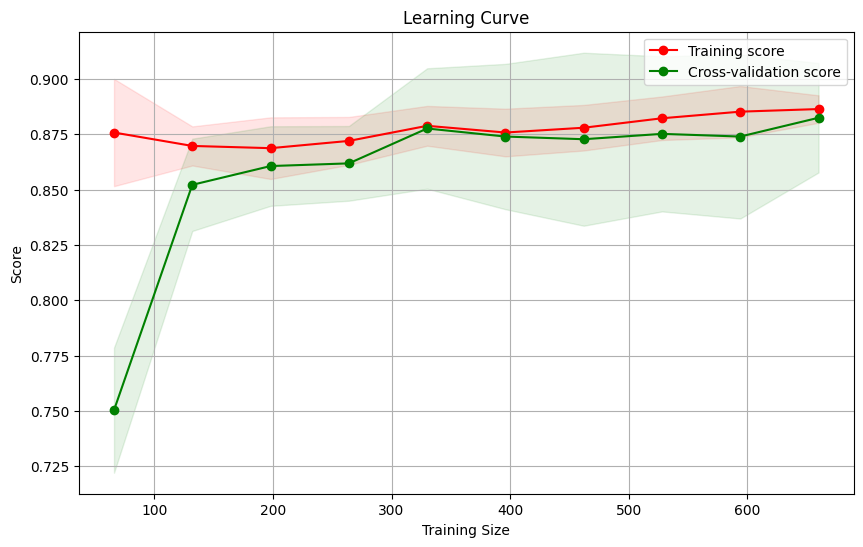


 DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_split=15)
Tumor stage Predictor's accuracy:  0.88


In [187]:
#Plotting training vs cross validation curves
plot_learning_curves(grid_search, x_train, y_train)

#Best classifier to predict tumor_stage
print("\n",best_model)
y_pred = best_model.predict(x_test)
print("Tumor stage Predictor's accuracy: ", accuracy_score(y_test, y_pred))


In [210]:
#Checking the accuracy and the score of the model through different metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

tumor_f1 = f1_score(y_test, y_pred, average = None)    #F1 for every class
print("\nTest tumor F1_score:", tumor_f1)
tumor_recall = recall_score(y_test, y_pred, average = None) #recall for every class
print("\nTest tumor Recall:", tumor_recall)
tumor_precision = precision_score(y_test, y_pred, average = None)   #precision for every class
print("\nTest tumor Precision:", tumor_precision)

print("\nTest tumor confusion matrix:", confusion_matrix(y_test, y_pred))   #confusion matrix

print("\nTest tumor classification report: ", classification_report(y_test, y_pred, target_names=["1", "2", "3"]))  #report



Test tumor F1_score: [0.9010989  0.89506173 0.65116279 0.        ]

Test tumor Recall: [0.85416667 0.9602649  0.51851852 0.        ]

Test tumor Precision: [0.95348837 0.83815029 0.875      0.        ]

Test tumor confusion matrix: [[ 82  14   0   0]
 [  4 145   2   0]
 [  0  13  14   0]
 [  0   1   0   0]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ValueError: Number of classes, 4, does not match size of target_names, 3. Try specifying the labels parameter

##### Here we will use our classifier to predct the missing values for all the rows in the dataset that had an empty tumor_stage column

In [211]:
#fill the null values of tumor stage with model predictions
X_tumor_test = tumor_stage_pred[["tumor_size","lymph_nodes_examined_positive","neoplasm_histologic_grade"]]

X_tumor_test.dropna(inplace=True)
#print("\nmissing values after: ", X_tumor_test.isna().sum())
y_pred = best_model.predict(X_tumor_test)    #getting the predictions on the test data which we extracted from the dataset (test data is all rows that had null values for tumor_stage

tumor_stage_pred["tumor_stage"] = y_pred     #filling the values of tumor_stage with our predicted values


data = data.dropna(subset=["tumor_stage"])

data = pd.concat([data, tumor_stage_pred], ignore_index=False, sort=False)
print("Data shape: ", data.shape, "\nData: ",data.head())
print(data["tumor_stage"])

Data shape:  (1493, 683) 
Data:                          cancer_type  age_at_diagnosis cellularity  \
0  Breast Invasive Ductal Carcinoma             54.29        High   
3  Breast Invasive Ductal Carcinoma             51.87        High   
4  Breast Invasive Ductal Carcinoma             87.18    Moderate   
5  Breast Invasive Ductal Carcinoma             78.55        High   
9  Breast Invasive Ductal Carcinoma             58.71    Moderate   

  pam50_+_claudin-low_subtype er_status  neoplasm_histologic_grade  \
0                        LumB  Positive                        3.0   
3                        LumA  Positive                        2.0   
4                        LumB  Positive                        3.0   
5                        LumB  Positive                        2.0   
9                        LumA  Positive                        3.0   

  her2_status_measured_by_snp6 her2_status  hormone_therapy  \
0                      NEUTRAL    Negative                1   
3    

/var/folders/9b/n7j6vvys083g7009y7vtvlh00000gn/T/ipykernel_74992/1853088411.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_tumor_test.dropna(inplace=True)


In [190]:
#dropping unnecessary column and checking number of missing values after predicting tumor_stage column
data = data.drop(columns=["level_0","index"])
print(data.shape)
print("\nmissing values: ", data.isnull().sum().sum())

(1493, 681)

missing values:  71


#### Encoding categorical features and then filling null values with means.


In [212]:
#Using Label Encoder to encode categorical features in the data
from sklearn.preprocessing import LabelEncoder
categorical = data.select_dtypes(exclude="number")
categorical = categorical.drop(columns="cancer_type")


data = data.drop(columns=categorical)

categorical = categorical.astype(str)

label_encoder = LabelEncoder()
categorical = categorical.apply(LabelEncoder().fit_transform)

data = pd.concat([data,categorical], axis=1)
print("full dataset with encoded values :", data)


full dataset with encoded values :                           cancer_type  age_at_diagnosis  \
0    Breast Invasive Ductal Carcinoma             54.29   
3    Breast Invasive Ductal Carcinoma             51.87   
4    Breast Invasive Ductal Carcinoma             87.18   
5    Breast Invasive Ductal Carcinoma             78.55   
9    Breast Invasive Ductal Carcinoma             58.71   
..                                ...               ...   
388  Breast Invasive Ductal Carcinoma             52.90   
389  Breast Invasive Ductal Carcinoma             50.08   
390  Breast Invasive Ductal Carcinoma             60.99   
391  Breast Invasive Ductal Carcinoma             83.39   
392  Breast Invasive Ductal Carcinoma             60.63   

     neoplasm_histologic_grade  hormone_therapy  \
0                          3.0                1   
3                          2.0                0   
4                          3.0                1   
5                          2.0                1   
9

In [213]:
#fill null values with means
print(data.isna().sum().sum())
label = data["cancer_type"]
data = data.drop(columns="cancer_type")
print(data)
mean = data.mean()
data.fillna(mean, inplace=True)
print(data.shape)
print(data.isna().sum().sum())
data = pd.concat([label,data], axis=1)
data

2231
     age_at_diagnosis  neoplasm_histologic_grade  hormone_therapy  \
0               54.29                        3.0                1   
3               51.87                        2.0                0   
4               87.18                        3.0                1   
5               78.55                        2.0                1   
9               58.71                        3.0                1   
..                ...                        ...              ...   
388             52.90                        2.0                1   
389             50.08                        1.0                1   
390             60.99                        1.0                1   
391             83.39                        3.0                1   
392             60.63                        3.0                1   

     lymph_nodes_examined_positive  mutation_count  \
0                                3             2.0   
3                                0            10.0   
4   

,cancer_type,age_at_diagnosis,neoplasm_histologic_grade,hormone_therapy,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,overall_survival_months,overall_survival,tumor_size,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,Breast Invasive Ductal Carcinoma,54.29,3.0,1,3,2.0,5.160,111.100000,0,80.000000,...,0,0,0,0,0,0,0,0,0,0
3,Breast Invasive Ductal Carcinoma,51.87,2.0,0,0,10.0,3.028,220.233333,1,14.000000,...,0,0,0,0,0,0,0,0,0,0
4,Breast Invasive Ductal Carcinoma,87.18,3.0,1,2,1.0,5.052,28.600000,0,26.000000,...,0,0,0,0,0,0,0,0,0,0
5,Breast Invasive Ductal Carcinoma,78.55,2.0,1,4,5.0,5.070,38.166667,0,35.000000,...,0,0,0,0,0,0,0,0,0,0
9,Breast Invasive Ductal Carcinoma,58.71,3.0,1,0,1.0,4.036,23.800000,1,18.000000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388,Breast Invasive Ductal Carcinoma,52.90,2.0,1,1,3.0,4.030,78.466667,0,15.000000,...,0,0,0,0,0,0,0,0,0,0
389,Breast Invasive Ductal Carcinoma,50.08,1.0,1,3,2.0,2.036,194.700000,0,18.000000,...,0,0,0,0,0,0,0,0,0,0
390,Breast Invasive Ductal Carcinoma,60.99,1.0,1,1,7.0,2.000,355.200000,0,28.811074,...,0,0,0,0,0,0,0,0,0,0
391,Breast Invasive Ductal Carcinoma,83.39,3.0,1,1,5.0,5.060,29.900000,0,30.000000,...,0,0,0,0,0,0,0,0,0,0


In [214]:
#Checking number of missing values
print(data.isna().sum().sum())

0


### Normalizing the data with z-score

In [215]:
#Normalizing the data
from sklearn.preprocessing import StandardScaler

label = data["cancer_type"]
data = data.drop(columns="cancer_type")
data_z_scaled = data.copy() 
  
#looping through every column to normalize with z-score
for column in data_z_scaled.columns: 
    data_z_scaled[column] = (data_z_scaled[column] - data_z_scaled[column].mean()) / data_z_scaled[column].std()  
    

data = pd.concat([label,data_z_scaled], axis=1)
data = data.fillna(0)        #because one column has only 0 values when computing the z score we got an undefined result and led to a lot of NAN.
  


### Splitting the data 

In [216]:
#Splitting the data (70-30)
from sklearn.model_selection import train_test_split

y = data["cancer_type"]
x = data.drop(columns="cancer_type")


x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, test_size = 0.3, random_state=3, shuffle = True)



x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size = 0.1, random_state=3, shuffle = True)

### Our Model

In [219]:
#importing necessary libraries

from sklearn.ensemble import RandomForestClassifier

,age_at_diagnosis,neoplasm_histologic_grade,hormone_therapy,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,overall_survival_months,overall_survival,tumor_size,tumor_stage,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,0.005957,0.916844,0.776690,-0.005814,-0.657171,0.883741,-0.396452,1.157250,-0.075987,0.380542,...,-0.041523,-0.041523,-0.034731,-0.041523,-0.034731,-0.034731,-0.034731,-0.02588,-0.02588,-0.02588
1,0.681298,-0.530141,0.776690,-0.005814,1.012927,-0.010931,1.793748,1.157250,-0.742622,0.380542,...,-0.041523,-0.041523,-0.034731,-0.041523,-0.034731,-0.034731,-0.034731,-0.02588,-0.02588,-0.02588
2,1.218624,0.916844,0.776690,0.490170,0.297171,1.752099,-1.037027,-0.863539,-0.409305,0.380542,...,-0.041523,-0.041523,-0.034731,-0.041523,-0.034731,-0.034731,-0.034731,-0.02588,-0.02588,-0.02588
3,0.270356,0.916844,-1.286652,-0.253805,0.058586,0.839885,0.022874,-0.863539,-0.075533,2.066446,...,-0.041523,-0.041523,-0.034731,-0.041523,-0.034731,-0.034731,-0.034731,-0.02588,-0.02588,-0.02588
4,-0.037463,0.916844,0.776690,-0.501797,-0.895756,-0.002159,-0.873932,-0.863539,-0.409305,-1.305361,...,-0.041523,-0.041523,-0.034731,-0.041523,-0.034731,-0.034731,-0.034731,-0.02588,-0.02588,-0.02588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3335,0.430856,0.916844,0.776690,-0.005814,0.058586,0.866198,-0.234668,-0.863539,-0.742622,0.380542,...,-0.041523,-0.041523,-0.034731,-0.041523,-0.034731,-0.034731,-0.034731,-0.02588,-0.02588,-0.02588
3336,-0.400333,0.916844,0.776690,1.730129,0.535756,1.752099,0.775824,-0.863539,-0.409305,0.380542,...,-0.041523,-0.041523,-0.034731,-0.041523,-0.034731,-0.034731,-0.034731,-0.02588,-0.02588,-0.02588
3337,-0.519738,-1.977126,-1.286652,-0.501797,0.058586,-1.765189,-1.044023,-0.863539,-0.742622,-1.305361,...,-0.041523,-0.041523,-0.034731,-0.041523,-0.034731,-0.034731,-0.034731,-0.02588,-0.02588,-0.02588
3338,0.447138,-0.530141,0.776690,-0.253805,0.297171,0.003104,-0.330426,-0.863539,-0.209314,0.380542,...,-0.041523,-0.041523,-0.034731,-0.041523,-0.034731,-0.034731,-0.034731,-0.02588,-0.02588,-0.02588


In [ ]:
#Random Forest model
CLF = RandomForestClassifier(max_depth=20,'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100)
CLF.fit(x_train_val,y_train_val)
